## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import preprocessing
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

## Import data

In [2]:
df = pd.read_csv("data.csv", index_col=0)
df.head()

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


## Helpful functions

In [3]:
# a function to show best hyperparamters, it takes a dictionary of best parameters
def print_best_params(best_params):
    print("- Best Hyperparameters:\n")
    index = 1
    for key, value in best_params.items():
        print(f"\t{index}- The best {key} is: {value}")
        index += 1
    print("-----------------------------------------------------------------------")    
# a function to show evaluation metrics, it takes actual values and predicted values
def print_eval_metrics(y_actual, y_pred):

    print(f"\t1- The Recall is: {round(metrics.recall_score(y_actual, y_pred)*100)}%")
    print(f"\t1- The Precision is: {round(metrics.precision_score(y_actual, y_pred)*100)}%")
    print(f"\t1- The F1-score is: {round(metrics.f1_score(y_actual, y_pred)*100)}%")
    print("-----------------------------------------------------------------------")
    
# a function to show the confusion matrix graph
def plot_conf_matrix(actual, pred):
    confusion_matrix = metrics.confusion_matrix(actual, pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
    plt.show()
# a function to plot the ROC curve
def plot_roc(y_test,predicted_test_proba,title = None,algorithm = None):

    no_skill_proba = [0 for _ in range(len(y_test))]

    # calculate roc curve
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_test_proba)
    ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, no_skill_proba)
    # calculate AUC
    auc = metrics.roc_auc_score(y_test, predicted_test_proba)
    no_skill_auc = metrics.roc_auc_score(y_test, no_skill_proba)
    print('AUC: %.4f' % auc)
    plt.plot(fpr, tpr, label=f"ROC curve (area = {round(auc*100,4)}% -- {algorithm})", lw=2)

    if title is not None:
        print('No Skill AUC: %.4f' % no_skill_auc)
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill', lw=2)

    # plot the roc curve for the model
    

    plt.title(f"Receiver operating characteristic --{title}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend()

## Exploratory Data Analysis(EDA)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 863 entries, 0 to 862
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   location      863 non-null    int64  
 1   country       863 non-null    int64  
 2   gender        863 non-null    int64  
 3   age           863 non-null    float64
 4   vis_wuhan     863 non-null    int64  
 5   from_wuhan    863 non-null    int64  
 6   symptom1      863 non-null    int64  
 7   symptom2      863 non-null    int64  
 8   symptom3      863 non-null    int64  
 9   symptom4      863 non-null    int64  
 10  symptom5      863 non-null    int64  
 11  symptom6      863 non-null    int64  
 12  diff_sym_hos  863 non-null    int64  
 13  result        863 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 101.1 KB


In [5]:
# check no. of classes
df["result"].unique()

array([1, 0], dtype=int64)

In [6]:
df["result"].value_counts()

0    755
1    108
Name: result, dtype: int64

In [7]:
# show the percentage of majority of class 1 to class 0.
class0 = df["result"].value_counts()[0]
class1 = df["result"].value_counts()[1]
no_salmples = len(df["result"])
class0 = round((class0 / no_salmples)*100)
class1 = round((class1 / no_salmples)*100)
print(f"the percentage of each class to the other is: {class1}:{class0}")

the percentage of each class to the other is: 13:87


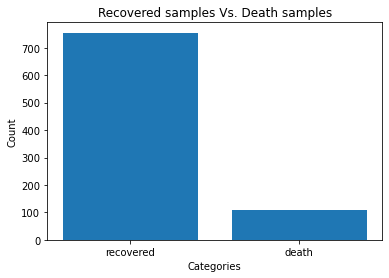

In [8]:
# plotting No. recovered samples and No. death samples
plt.bar(["recovered", "death"], df["result"].value_counts())
plt.title("Recovered samples Vs. Death samples")
plt.ylabel("Count")
plt.xlabel("Categories");

- Data seems to be imbalanced, where no. data samples of recovered class is greater than death class significantly. 
- This imbalancing will affect on the result of class 1 (death), where the evaluation metrics will be high on class 0, but very low on class 1

In [9]:
df["age"].describe()

count    863.000000
mean      49.400000
std       15.079203
min        2.000000
25%       40.000000
50%       49.400000
75%       57.000000
max       96.000000
Name: age, dtype: float64

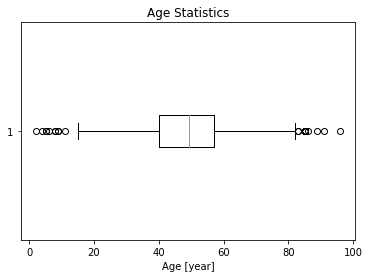

In [10]:
# plotting a whisker plot of age column
plt.boxplot(df["age"], vert=False)
plt.title("Age Statistics")
plt.xlabel("Age [year]");

- We notice that range from 40 to 60 of age represents the majority of patients 

### Comparing each feature with target to see the relationship between them using Pearson Correlation

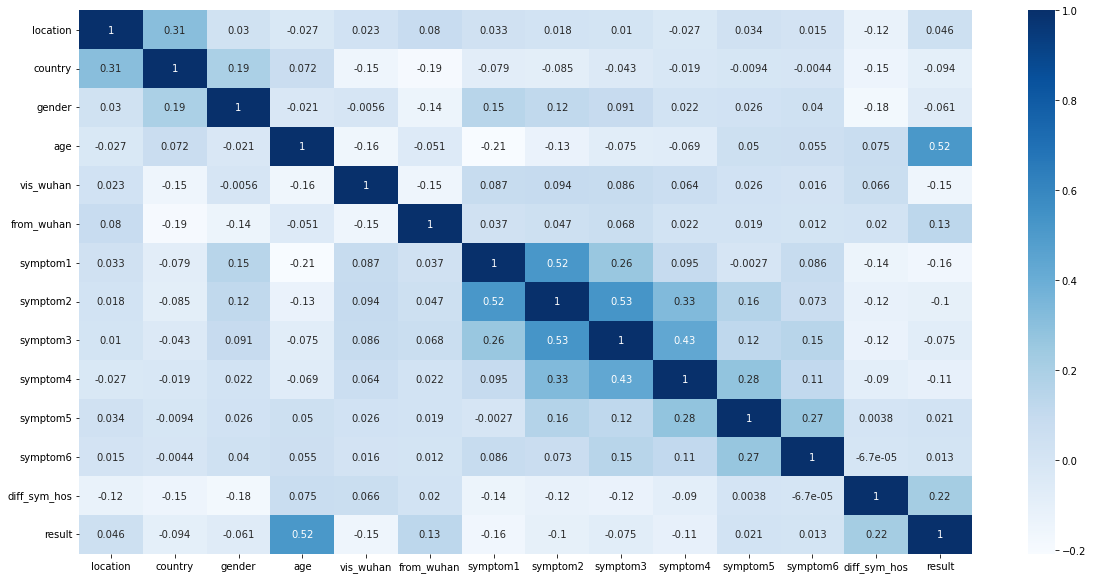

In [11]:
cor = df.corr()
plt.figure(figsize=(20, 10))
sn.heatmap(cor, annot=True, cmap="Blues")
plt.show()

location        0.046240
country        -0.094443
gender         -0.061441
age             0.515127
vis_wuhan      -0.151122
from_wuhan      0.128314
symptom1       -0.163039
symptom2       -0.103270
symptom3       -0.074982
symptom4       -0.108723
symptom5        0.020676
symptom6        0.012882
diff_sym_hos    0.219116
Name: result, dtype: float64


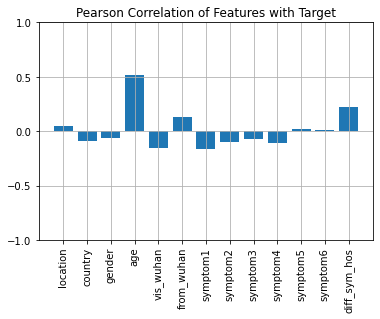

In [12]:
# print the pearson correlation values of features with target 
target_cor = cor["result"][: -1]
print(target_cor)
#Using Pearson Correlation plot the relationship
heights = cor["result"][: -1]
positions = df.columns[: -1]
plt.bar(positions, heights)
plt.title("Pearson Correlation of Features with Target")
plt.xticks(rotation=90)
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.grid();

- Age feature has the biggest relationship(0.5) with the target

##  Splitting the data

In [13]:
# select the features
features = df.columns[:-1]
features

Index(['location', 'country', 'gender', 'age', 'vis_wuhan', 'from_wuhan',
       'symptom1', 'symptom2', 'symptom3', 'symptom4', 'symptom5', 'symptom6',
       'diff_sym_hos'],
      dtype='object')

In [14]:
# get samples and target
X = df[features]
y = df["result"]
# Get train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), 
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    random_state=1, 
                                                    stratify=y)

- to solve the problem of imbalance data we will oversample the class 1. 

In [15]:
from collections import Counter
from imblearn.over_sampling import SMOTE
# summarize class distribution
print("Before oversampling: ",Counter(y_train))

Before oversampling:  Counter({0: 604, 1: 86})


In [16]:
SMOTE = SMOTE()
# fit and apply the transform
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)


In [17]:
# summarize class distribution
print("After oversampling: ",Counter(y_train_SMOTE))

After oversampling:  Counter({0: 604, 1: 604})


In [18]:
X_train.head()

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos
524,114,29,2,49.4,0,1,14,31,19,12,3,1,0
306,117,18,1,45.0,0,0,6,17,19,12,3,1,0
208,22,18,1,45.0,0,1,14,31,19,12,3,1,3
385,106,23,0,71.0,0,0,14,31,19,12,3,1,0
663,121,30,2,49.4,0,0,14,31,19,12,3,1,0


## Building models

In [19]:
def grid_search_hyper(model, params, X_train, y_train, X_test):
    """This function for tuning a model and train it using GridSearchCV object
        inputs:
            model: the model you want to tune and train
            params: the hyperparameters that will be tuned
             X_train, y_train, X_test: data for train test
        outputs:
            grid.best_params_[1]: a dictioinary of best hyperparameters for the model
            y_train_pred: the predicted train y 
            y_test_pred: the predicted test y
            predicted_test_proba: the predicted probabilty test y
            grid: the trained GridSearchCV with best hyperparameters accessable"""
    
    grid = GridSearchCV(estimator=model,
                        param_grid=params, 
                        scoring='accuracy', 
                        cv=10,
                        return_train_score=False,
                        refit=True,
                        verbose=1) 

    # training and Prediction
    grid.fit(X_train, y_train)
    # using the best estimator(the model with best hyperparameters) to predict the target using training and testing data
    y_train_pred = grid.best_estimator_.predict(X_train)
    y_test_pred = grid.best_estimator_.predict(X_test)
    # predict the probabilty of each sample to make smooth curve
    predicted_test_proba = grid.best_estimator_.predict_proba(X_test)
    
    return grid.best_params_, y_train_pred, y_test_pred, predicted_test_proba, grid

## 1. K-Nearest Neighbors model

* We will not use any data transformation

In [20]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_params = { 'n_neighbors' : range(2, 30)}
# use data x_train and y_train(not oversampled)
knn_best, knn_train_pred, knn_test_pred, knn_test_proba_pred, knn = grid_search_hyper(knn, knn_params,
                                                                                X_train, y_train, X_test)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


In [21]:
print(knn.best_estimator_)

KNeighborsClassifier()


In [22]:
# Print the best hyperparameters for KNN algo.
print_best_params(knn_best)

# Print the evaluation metrics of training data for KNN algo.
print("-Training evaluation metrics:\n")
print_eval_metrics(y_train, knn_train_pred)

# show the classification report for testing data
print("- The calssification report for training data\n")
print(f"{metrics.classification_report(y_train, knn_train_pred)}")

print("-----------------------------------------------------------------------")
# Print the evaluation metrics of testing data for KNN algo.
print("-Testing evaluation metrics:\n")
print_eval_metrics(y_test, knn_test_pred)

# show the classification report for testing data
print("- The calssification report for testing data\n")
print(f"{metrics.classification_report(y_test, knn_test_pred)}")

- Best Hyperparameters:

	1- The best n_neighbors is: 5
-----------------------------------------------------------------------
-Training evaluation metrics:

	1- The Recall is: 72%
	1- The Precision is: 89%
	1- The F1-score is: 79%
-----------------------------------------------------------------------
- The calssification report for training data

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       604
           1       0.89      0.72      0.79        86

    accuracy                           0.95       690
   macro avg       0.92      0.85      0.88       690
weighted avg       0.95      0.95      0.95       690

-----------------------------------------------------------------------
-Testing evaluation metrics:

	1- The Recall is: 64%
	1- The Precision is: 93%
	1- The F1-score is: 76%
-----------------------------------------------------------------------
- The calssification report for testing data

              precision    

The confusion matrix of Training predicted data


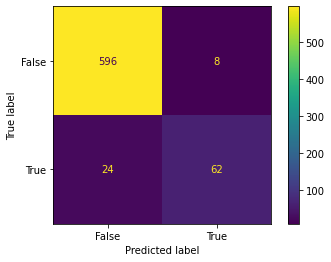

----------------------------------------------------------
The confusion matrix of Testing predicted data


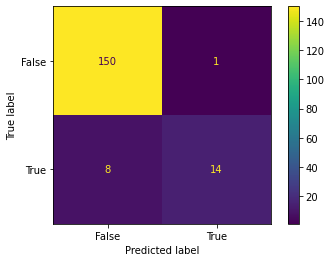

In [23]:
# show the confusion matrix of training data
print("The confusion matrix of Training predicted data")
plot_conf_matrix(y_train, knn_train_pred)
print("----------------------------------------------------------")
# show the confusion matrix of testing data
print("The confusion matrix of Testing predicted data")
plot_conf_matrix(y_test, knn_test_pred)

AUC: 0.9901
No Skill AUC: 0.5000


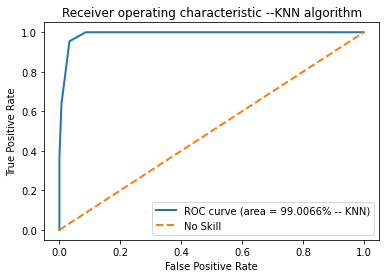

In [24]:
# plotting the ROC curve for KNN algorithm
plot_roc(y_test,knn_test_proba_pred[:,1], title="KNN algorithm", algorithm="KNN")

## 2. Logistic Regression

* We will use oversampling technique with this algorithm

In [25]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
logr_params = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear']}
# use oversampled data x_train_SMOTE and y_train_SMOTE
logr_best, logr_train_pred, logr_test_pred, logr_test_proba_pred, logr = grid_search_hyper(logr, logr_params, 
                                                                                     X_train_SMOTE, y_train_SMOTE, X_test)

Fitting 10 folds for each of 42 candidates, totalling 420 fits


In [26]:
print(logr.best_estimator_)

LogisticRegression(C=10.0)


In [27]:
# Print the best hyperparameters for Logistic Regression algo.
print_best_params(logr_best)

# Print the evaluation metrics of training data for Logistic Regression algo.
print("-Training evaluation metrics:\n")
print_eval_metrics(y_train_SMOTE, logr_train_pred)

# show the classification report for testing data
print("- The calssification report for training data\n")
print(f"{metrics.classification_report(y_train_SMOTE, logr_train_pred)}")

print("-----------------------------------------------------------------------")
# Print the evaluation metrics of testing data for Logistic Regression algo.
print("-Testing evaluation metrics:\n")
print_eval_metrics(y_test, logr_test_pred)

# show the classification report for testing data
print("- The calssification report for testing data\n")
print(f"{metrics.classification_report(y_test, logr_test_pred)}")

- Best Hyperparameters:

	1- The best C is: 10.0
	2- The best penalty is: l2
	3- The best solver is: lbfgs
-----------------------------------------------------------------------
-Training evaluation metrics:

	1- The Recall is: 92%
	1- The Precision is: 90%
	1- The F1-score is: 91%
-----------------------------------------------------------------------
- The calssification report for training data

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       604
           1       0.90      0.92      0.91       604

    accuracy                           0.91      1208
   macro avg       0.91      0.91      0.91      1208
weighted avg       0.91      0.91      0.91      1208

-----------------------------------------------------------------------
-Testing evaluation metrics:

	1- The Recall is: 100%
	1- The Precision is: 67%
	1- The F1-score is: 80%
-----------------------------------------------------------------------
- The calssification 

The confusion matrix of Training predicted data


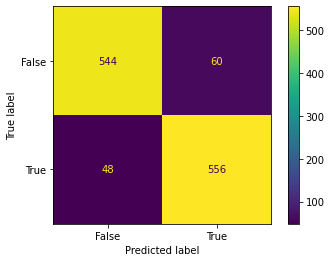

----------------------------------------------------------
The confusion matrix of Testing predicted data


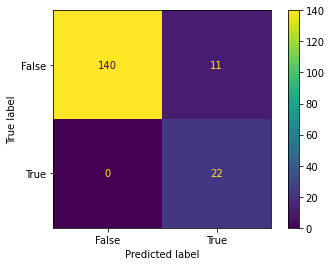

In [28]:
# show the confusion matrix of training data
print("The confusion matrix of Training predicted data")
plot_conf_matrix(y_train_SMOTE, logr_train_pred)
print("----------------------------------------------------------")
# show the confusion matrix of testing data
print("The confusion matrix of Testing predicted data")
plot_conf_matrix(y_test, logr_test_pred)

AUC: 0.9804
No Skill AUC: 0.5000


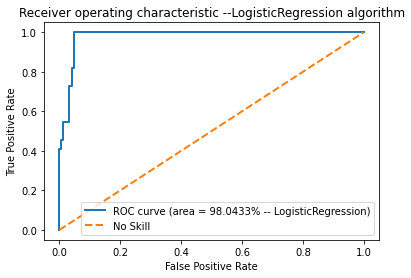

In [29]:
# plotting the ROC curve for Logistic Regression algorithm
plot_roc(y_test,logr_test_proba_pred[:,1], title="LogisticRegression algorithm", algorithm="LogisticRegression")

## 3. Naïve Bayes

* We will use oversampling technique with this algorithm

In [30]:
from sklearn.naive_bayes import GaussianNB
gauNB = GaussianNB()
gauNB_params = {'var_smoothing': np.logspace(0, -10, num=200)}
# use oversampled data x_train_SMOTE and y_train_SMOTE
gauNB_best, gauNB_train_pred, gauNB_test_pred, gauNB_test_proba_pred, gauNB = grid_search_hyper(gauNB, gauNB_params, 
                                                                                     X_train_SMOTE, y_train_SMOTE, X_test)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


In [31]:
print(gauNB.best_estimator_)

GaussianNB(var_smoothing=0.05542664520663104)


In [32]:
# Print the best hyperparameters for GaussianNB algo.
print_best_params(gauNB_best)

# Print the evaluation metrics of training data for GaussianNB algo.
print("-Training evaluation metrics:\n")
print_eval_metrics(y_train_SMOTE, gauNB_train_pred)

# show the classification report for testing data
print("- The calssification report for training data\n")
print(f"{metrics.classification_report(y_train_SMOTE, gauNB_train_pred)}")

print("-----------------------------------------------------------------------")
# Print the evaluation metrics of testing data for GaussianNB algo.
print("-Testing evaluation metrics:\n")
print_eval_metrics(y_test, gauNB_test_pred)

# show the classification report for testing data
print("- The calssification report for testing data\n")
print(f"{metrics.classification_report(y_test, gauNB_test_pred)}")

- Best Hyperparameters:

	1- The best var_smoothing is: 0.05542664520663104
-----------------------------------------------------------------------
-Training evaluation metrics:

	1- The Recall is: 91%
	1- The Precision is: 87%
	1- The F1-score is: 89%
-----------------------------------------------------------------------
- The calssification report for training data

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       604
           1       0.87      0.91      0.89       604

    accuracy                           0.89      1208
   macro avg       0.89      0.89      0.89      1208
weighted avg       0.89      0.89      0.89      1208

-----------------------------------------------------------------------
-Testing evaluation metrics:

	1- The Recall is: 100%
	1- The Precision is: 55%
	1- The F1-score is: 71%
-----------------------------------------------------------------------
- The calssification report for testing data

      

The confusion matrix of Training predicted data


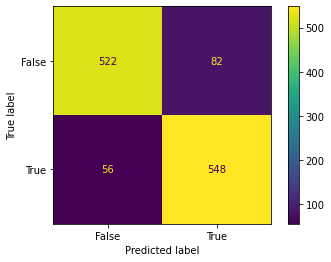

----------------------------------------------------------
The confusion matrix of Testing predicted data


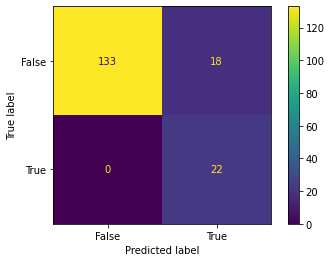

In [33]:
# show the confusion matrix of training data
print("The confusion matrix of Training predicted data")
plot_conf_matrix(y_train_SMOTE, gauNB_train_pred)
print("----------------------------------------------------------")
# show the confusion matrix of testing data
print("The confusion matrix of Testing predicted data")
plot_conf_matrix(y_test, gauNB_test_pred)

AUC: 0.9840
No Skill AUC: 0.5000


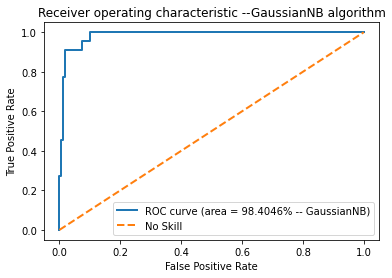

In [34]:
# plotting the ROC curve for GaussianNB algorithm
plot_roc(y_test,gauNB_test_proba_pred[:,1], title="GaussianNB algorithm", algorithm="GaussianNB")

## 4. Decision Tree:

* We will use oversampling technique with this algorithm

In [35]:
from sklearn.tree import DecisionTreeClassifier
decT = DecisionTreeClassifier()
decT_params = {"criterion": ['gini', 'entropy'],
               "max_depth": [2,4,6,8,10,12],
               "min_samples_leaf": range(5, 10)}
# use oversampled data x_train_SMOTE and y_train_SMOTE
decT_best, decT_train_pred, decT_test_pred, decT_test_proba_pred, decT = grid_search_hyper(decT, decT_params, 
                                                                                     X_train_SMOTE, y_train_SMOTE, X_test)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


In [36]:
print(decT.best_estimator_)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=5)


In [37]:
# Print the best hyperparameters for DecisionTreeClassifier algo.
print_best_params(decT_best)

# Print the evaluation metrics of training data for DecisionTreeClassifier algo.
print("-Training evaluation metrics:\n")
print_eval_metrics(y_train_SMOTE, decT_train_pred)

# show the classification report for testing data
print("- The calssification report for training data\n")
print(f"{metrics.classification_report(y_train_SMOTE, decT_train_pred)}")

print("-----------------------------------------------------------------------")
# Print the evaluation metrics of testing data for DecisionTreeClassifier algo.
print("-Testing evaluation metrics:\n")
print_eval_metrics(y_test, decT_test_pred)

# show the classification report for testing data
print("- The calssification report for testing data\n")
print(f"{metrics.classification_report(y_test, decT_test_pred)}")

- Best Hyperparameters:

	1- The best criterion is: gini
	2- The best max_depth is: 8
	3- The best min_samples_leaf is: 5
-----------------------------------------------------------------------
-Training evaluation metrics:

	1- The Recall is: 99%
	1- The Precision is: 97%
	1- The F1-score is: 98%
-----------------------------------------------------------------------
- The calssification report for training data

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       604
           1       0.97      0.99      0.98       604

    accuracy                           0.98      1208
   macro avg       0.98      0.98      0.98      1208
weighted avg       0.98      0.98      0.98      1208

-----------------------------------------------------------------------
-Testing evaluation metrics:

	1- The Recall is: 95%
	1- The Precision is: 81%
	1- The F1-score is: 88%
-----------------------------------------------------------------------
- The c

The confusion matrix of Training predicted data


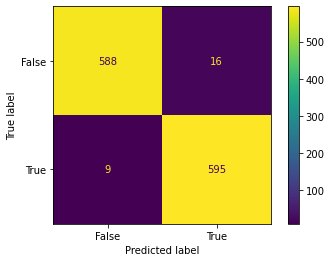

----------------------------------------------------------
The confusion matrix of Testing predicted data


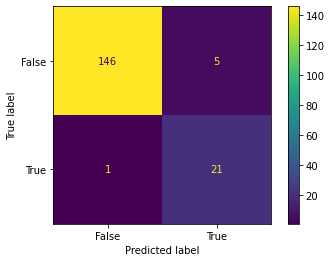

In [38]:
# show the confusion matrix of training data
print("The confusion matrix of Training predicted data")
plot_conf_matrix(y_train_SMOTE, decT_train_pred)
print("----------------------------------------------------------")
# show the confusion matrix of testing data
print("The confusion matrix of Testing predicted data")
plot_conf_matrix(y_test, decT_test_pred)

AUC: 0.9658
No Skill AUC: 0.5000


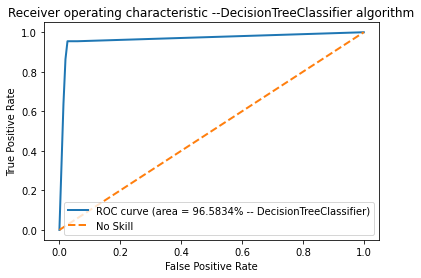

In [39]:
# plotting the ROC curve for DecisionTreeClassifier algorithm
plot_roc(y_test,decT_test_proba_pred[:,1], title="DecisionTreeClassifier algorithm", algorithm="DecisionTreeClassifier")

## 5. Support Vector Machines:

* We will not use any data transformation

In [40]:
from sklearn.svm import SVC
svc = SVC(probability=True)
svc_params ={"C": [0.1, 1, 10, 100, 1000], 
             "gamma": [1, 0.1, 0.01, 0.001, 0.0001]}
# use data x_train and y_train(not oversampled)
svc_best, svc_train_pred, svc_test_pred, svc_test_proba_pred, svc = grid_search_hyper(svc, svc_params, 
                                                                                     X_train, y_train, X_test)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


In [41]:
print(svc.best_estimator_)

SVC(C=1000, gamma=0.0001, probability=True)


In [42]:
# Print the best hyperparameters for SVC algo.
print_best_params(svc_best)

# Print the evaluation metrics of training data for SVC algo.
print("-Training evaluation metrics:\n")
print_eval_metrics(y_train, svc_train_pred)

# show the classification report for testing data
print("- The calssification report for training data\n")
print(f"{metrics.classification_report(y_train, svc_train_pred)}")

print("-----------------------------------------------------------------------")
# Print the evaluation metrics of testing data for SVC algo.
print("-Testing evaluation metrics:\n")
print_eval_metrics(y_test, svc_test_pred)

# show the classification report for testing data
print("- The calssification report for testing data\n")
print(f"{metrics.classification_report(y_test, svc_test_pred)}")

- Best Hyperparameters:

	1- The best C is: 1000
	2- The best gamma is: 0.0001
-----------------------------------------------------------------------
-Training evaluation metrics:

	1- The Recall is: 93%
	1- The Precision is: 99%
	1- The F1-score is: 96%
-----------------------------------------------------------------------
- The calssification report for training data

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       604
           1       0.99      0.93      0.96        86

    accuracy                           0.99       690
   macro avg       0.99      0.96      0.98       690
weighted avg       0.99      0.99      0.99       690

-----------------------------------------------------------------------
-Testing evaluation metrics:

	1- The Recall is: 91%
	1- The Precision is: 100%
	1- The F1-score is: 95%
-----------------------------------------------------------------------
- The calssification report for testing data

   

The confusion matrix of Training predicted data


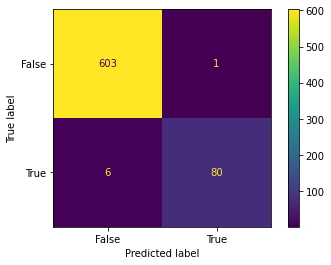

----------------------------------------------------------
The confusion matrix of Testing predicted data


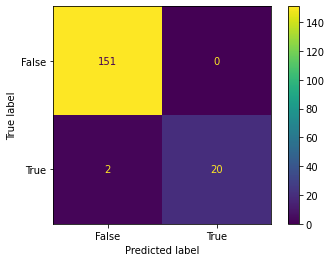

In [43]:
# show the confusion matrix of training data
print("The confusion matrix of Training predicted data")
plot_conf_matrix(y_train, svc_train_pred)
print("----------------------------------------------------------")
# show the confusion matrix of testing data
print("The confusion matrix of Testing predicted data")
plot_conf_matrix(y_test, svc_test_pred)

AUC: 0.9991
No Skill AUC: 0.5000


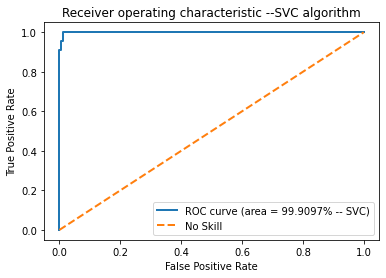

In [44]:
# plotting the ROC curve for SVC algorithm
plot_roc(y_test,svc_test_proba_pred[:,1], title="SVC algorithm", algorithm="SVC")

## Comparing the five algorithms with ROC Curve:

AUC: 0.9901
AUC: 0.9804
AUC: 0.9840
AUC: 0.9658
AUC: 0.9991
No Skill AUC: 0.5000


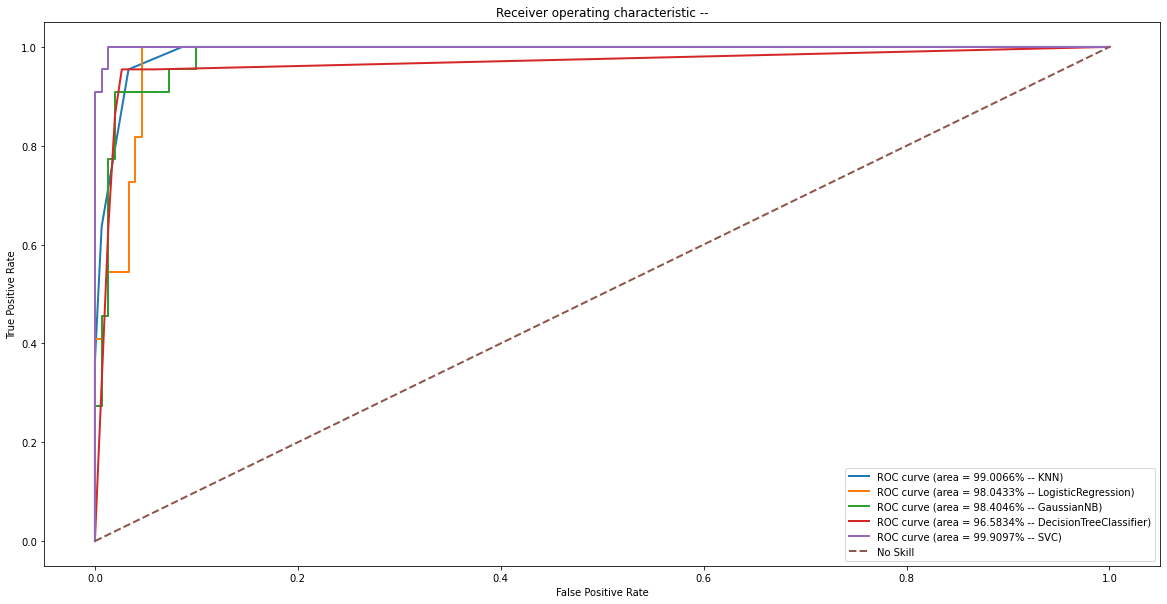

In [45]:
# plot the five ROC curves together to show the differences
plt.figure(figsize=(20,10))
# plotting the ROC curve for KNN algorithm
plot_roc(y_test,knn_test_proba_pred[:,1], algorithm="KNN")
# plotting the ROC curve for Logistic Regression algorithm
plot_roc(y_test,logr_test_proba_pred[:,1], algorithm="LogisticRegression")
# plotting the ROC curve for GaussianNB algorithm
plot_roc(y_test,gauNB_test_proba_pred[:,1], algorithm="GaussianNB")
# plotting the ROC curve for DecisionTreeClassifier algorithm
plot_roc(y_test,decT_test_proba_pred[:,1], algorithm="DecisionTreeClassifier")
# plotting the ROC curve for SVC algorithm
plot_roc(y_test,svc_test_proba_pred[:,1], title="", algorithm="SVC")
plt.show()

- As we can see above Support Vector Machine has the highest AUC value, it's about 99.9% 